In [1]:
import gym
import random
from collections import deque
from collections import namedtuple
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
import numpy as np
import matplotlib.pyplot as plt
import math
environment = gym.make("LunarLander-v2")
environment.observation_space.shape[0]
Batch = namedtuple('Batch', ('state','next_state','action','reward','done'))

/Users/ethan/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ethan/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode: 0, Avg Reward: -196.436146192
Episode: 100, Avg Reward: -155.688450463
Episode: 200, Avg Reward: -60.4165625454
Episode: 300, Avg Reward: 160.404056451
Episode: 400, Avg Reward: 180.680132661
Episode: 500, Avg Reward: 234.768592743
Solved at Episode: 508 Avg Reward: 238.782877336


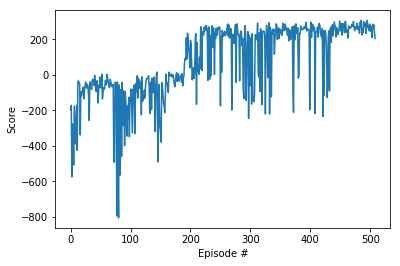

In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self, action_space, state_space):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(state_space, 128)
        self.layer_2 = nn.Linear(128, 128)
        self.output_layer = nn.Linear(128, action_space)
        
    def forward(self, x):
        layer1 = F.relu(self.layer_1(x))
        layer2 = F.relu(self.layer_2(layer1))
        return self.output_layer(layer2)
#This agent utilizes two neural networks. One neural network acts as the DQNfor selecting the next action, 
#which utilizes Q learning. The other neural network acts as the target network, the "true" Q-value that the 
#DQN tries to attain/predict in order to evaluate the quality of taking that next action. Using two neural networks
#helps prevent the problem with moving Q-targets as having a single neural network as the target and prediction
#means that the same weights are being used, which means that as we become closer to the target value, the target 
#value shifts due to backpropagation and gradient descent.
class Agent:
    def __init__(self, environment, epsilon, gamma, alpha):
        self.action_space = environment.action_space.n
        self.state_space = environment.observation_space.shape[0]
        self.epsilon = epsilon #probability for exploitation or exploration
        self.gamma = gamma #discount factor
        self.alpha = alpha #learning rates
        self.memory = deque(maxlen=int(1e5)) #experience replay to produce better results
        #self.targetNetwork = NeuralNetwork(self.action_space, self.state_space)
        self.Qnetwork = NeuralNetwork(self.action_space, self.state_space)
        self.targetNetwork = NeuralNetwork(self.action_space, self.state_space)
        self.optimizer = optim.Adam(self.Qnetwork.parameters(), lr=self.alpha)
    
    #This method helps with experience replay, allowing for a more stable agent.
    def add_to_memory(self, state, next_state, action, reward, done):
        state = torch.from_numpy(state)
        next_state = torch.from_numpy(next_state)
        action = torch.tensor([[action]])
        reward = torch.tensor([[reward]],dtype=torch.float)
        done = torch.tensor([[done]], dtype=torch.float)
        select_memory = Batch(state, next_state,action,reward,done)
        self.memory.append(select_memory)
    
    #This method allows the agent to randomly explore and exploit the learned features of the neural network.
    def take_action(self, state):
        #exploration
        if random.random() <= self.epsilon:
            return random.randint(0,self.action_space-1)
        #exploitation
        else:
            state = torch.from_numpy(state)
            Q_values = self.Qnetwork.forward(state)
            action = torch.argmax(Q_values).item()
            return action
        
    #This method allows the agent to only take a learned action. No more exploration.
    def action(self, state):
        state = torch.from_numpy(state)
        Q_values = self.Qnetwork.forward(state)
        action = torch.argmax(Q_values).item()
        return action
    
    def train_model(self, batch_size):
        if(len(self.memory) < batch_size):
            return
        small_memory = random.sample(self.memory, batch_size)
        small_memory = Batch(*zip(*small_memory))
        state_matrix = torch.cat(small_memory.state)
        next_state_matrix = torch.cat(small_memory.next_state)
        action_matrix = torch.cat(small_memory.action)
        reward_matrix = torch.cat(small_memory.reward)
        done_matrix = torch.cat(small_memory.done)
       
        predicted_Q = torch.gather(self.Qnetwork(state_matrix),1, action_matrix)
        #two neural networks to prevent oscillation (not double DQN yet)
        
        next_Q_value = torch.unsqueeze(self.targetNetwork(next_state_matrix).detach().max(1)[0],1)
        target_Q = reward_matrix + self.gamma*(next_Q_value)*(1-done_matrix)
            
        self.optimizer.zero_grad()
        loss = F.mse_loss(predicted_Q, target_Q)
        loss.backward()
        self.optimizer.step()
        self.update_target_network()
    
    def update_target_network(self):
        for target_param, local_param in zip(self.targetNetwork.parameters(), self.Qnetwork.parameters()):
            target_param.data.copy_((1e-3)*local_param.data + (1.0-(1e-3))*target_param.data)


def testing(environment, time_steps):
    agent = Agent(environment,epsilon=1.0,gamma=0.99,alpha=5e-4)
    scores = []
    scores_window = deque(maxlen=100)
    episode = 0 
    while np.mean(scores_window) < 235 or math.isnan(np.mean(scores_window)):
    #for episode in range(episodeNum):
        state = environment.reset()
        state = np.reshape(state, (1,environment.observation_space.shape[0]))
        total_reward = 0
        for time_step in range(time_steps):
            environment.render()
            action = agent.take_action(state)
            next_state, reward, done, _ = environment.step(action)
            agent.train_model(64)
            next_state = np.reshape(next_state, (1,environment.observation_space.shape[0]))
            #add to experience replay
            agent.add_to_memory(state,next_state,action,reward,done)
            state = next_state
            total_reward += reward
            agent.epsilon = max(0.01, 0.995*agent.epsilon)
            if done:
                break
            agent.train_model(64)
        scores.append(total_reward)
        scores_window.append(total_reward)
        if episode % 100 == 0:
            print("Episode: {}, Avg Reward: {}".format(episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 235.0:
            print("Solved at Episode: {} Avg Reward: {}".format(episode, np.mean(scores_window)))
            break
        episode+=1
    environment.close()
    torch.save(agent.Qnetwork.state_dict(), './dqn.pth')
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    
testing(environment,1000)

In [9]:
def watch(environment):
    agent = Agent(environment,epsilon=1.0,gamma=0.99,alpha=5e-4)
    agent.Qnetwork.load_state_dict(torch.load('./dqn.pth'))

    for i in range(10):
        state = environment.reset()
        for j in range(400):
            state = np.reshape(state, (1,environment.observation_space.shape[0]))
            action = agent.action(state)
            environment.render()
            state, reward, done, _ = environment.step(action)
            if done:
                break        
    environment.close()
watch(environment)